In [1]:
import sys
print(sys.executable)
print(sys.path)

if '' in sys.path:
    sys.path.remove('')
    
if '/opt/apps/intel19/impi19_0/python3/3.7.0/lib/python3.7/site-packages' in sys.path:
    sys.path.remove('/opt/apps/intel19/impi19_0/python3/3.7.0/lib/python3.7/site-packages')


/work2/10000/wl87/anaconda3/envs/my_ml_env/bin/python
['', '/opt/apps/intel19/impi19_0/python3/3.7.0/lib/python3.7/site-packages', '/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python310.zip', '/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10', '/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/lib-dynload', '/home1/10000/wl87/.local/lib/python3.10/site-packages', '/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/site-packages', '/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/site-packages/setuptools/_vendor']


In [2]:
import logging
import anndata as ad
import numpy as np

from scipy.sparse import csc_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge

# load packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [3]:
logging.basicConfig(level=logging.INFO)


In [4]:
import pandas as pd

# 定义 Feather 文件所在的目录路径
directory_path = '/work/10000/wl87/imageCCA-master/outs/integrate/'


# 按顺序单独加载每个 Feather 文件
data_sample1_location = pd.read_feather(directory_path + "Lung_data_sample1_location.feather")
data_sample2_location = pd.read_feather(directory_path + "Lung_data_sample2_location.feather")
data_sample1_HEfeature = pd.read_feather(directory_path + "Lung_data_sample1_HEfeature.feather")
data_sample2_HEfeature = pd.read_feather(directory_path + "Lung_data_sample2_HEfeature.feather")
data_sample1_count = pd.read_feather(directory_path + "Lung_data_sample1_count.feather")
data_sample2_count = pd.read_feather(directory_path + "Lung_data_sample2_count.feather")
reduced_mtx_path1 = "/work/10000/wl87/BLEEP/lung_data/data/filtered_expression_matrices/1/harmony_matrix.npy"
reduced_mtx_path2 = "/work/10000/wl87/BLEEP/lung_data/data/filtered_expression_matrices/2/harmony_matrix.npy"
harmony_matrix1 = np.load(reduced_mtx_path1)
harmony_matrix2 = np.load(reduced_mtx_path2)
# 转置矩阵
harmony_matrix1 = harmony_matrix1.T
harmony_matrix2 = harmony_matrix2.T
data_sample1_celltype = pd.read_feather(directory_path + "Lung_data_sample1_HEcelltype_ratio.feather")
data_sample2_celltype = pd.read_feather(directory_path + "Lung_data_sample2_HEcelltype_ratio.feather")
data_sample1_integratedHE = pd.read_feather(directory_path + "Lung_data_sample1_integratedHE.feather")
data_sample2_integratedHE = pd.read_feather(directory_path + "Lung_data_sample2_integratedHE.feather")
print("Shape of harmony_matrix1:", harmony_matrix1.shape)
print("Shape of harmony_matrix2:", harmony_matrix2.shape)

Shape of harmony_matrix1: (6195, 1923)
Shape of harmony_matrix2: (3858, 1923)


In [5]:
# 先将每个 DataFrame 的 Barcode 列设置为索引
data_sample1_celltype.set_index('Barcode', inplace=True)
data_sample1_location.set_index('Barcode', inplace=True)
data_sample1_HEfeature.set_index('Barcode', inplace=True)
data_sample1_count.set_index('Barcode', inplace=True)
data_sample1_integratedHE.set_index('Barcode', inplace=True)
harmony_matrix1 = pd.DataFrame(harmony_matrix1, index=data_sample1_count.index)

In [6]:
# Filtering data_sample1_location, data_sample1_HEfeature, and data_sample1_count to only include rows present in data_sample1_celltype's index
data_sample1_location = data_sample1_location.loc[data_sample1_celltype.index]
data_sample1_HEfeature = data_sample1_HEfeature.loc[data_sample1_celltype.index]
data_sample1_count = data_sample1_count.loc[data_sample1_celltype.index]
data_sample1_integratedHE = data_sample1_integratedHE.loc[data_sample1_celltype.index]
harmony_matrix1 = harmony_matrix1.loc[data_sample1_celltype.index]

In [7]:
# 先将每个 DataFrame 的 Barcode 列设置为索引
data_sample2_celltype.set_index('Barcode', inplace=True)
data_sample2_location.set_index('Barcode', inplace=True)
data_sample2_HEfeature.set_index('Barcode', inplace=True)
data_sample2_count.set_index('Barcode', inplace=True)
data_sample2_integratedHE.set_index('Barcode', inplace=True)
harmony_matrix2 = pd.DataFrame(harmony_matrix2, index=data_sample2_count.index)


In [8]:
# Filtering data_sample1_location, data_sample1_HEfeature, and data_sample1_count to only include rows present in data_sample1_celltype's index
data_sample2_location = data_sample2_location.loc[data_sample2_celltype.index]
data_sample2_HEfeature = data_sample2_HEfeature.loc[data_sample2_celltype.index]
data_sample2_count = data_sample2_count.loc[data_sample2_celltype.index]
data_sample2_integratedHE = data_sample2_integratedHE.loc[data_sample2_celltype.index]
harmony_matrix2 = harmony_matrix2.loc[data_sample2_celltype.index]

In [9]:
print("data_sample1_location_sorted shape:", data_sample1_location.shape)
print("data_sample2_location_sorted shape:", data_sample2_location.shape)
print("data_sample1_HEfeature_sorted shape:", data_sample1_HEfeature.shape)
print("data_sample2_HEfeature_sorted shape:", data_sample2_HEfeature.shape)
print("data_sample1_count_sorted shape:", data_sample1_count.shape)
print("data_sample2_count_sorted shape:", data_sample2_count.shape)
print("data_sample1_celltype shape:", data_sample1_celltype.shape)
print("data_sample2_celltype shape:", data_sample2_celltype.shape)
print("data_sample1_integratedHE shape:", data_sample1_integratedHE.shape)
print("data_sample2_integratedHE shape:", data_sample2_integratedHE.shape)
print("harmony_matrix1 shape:", harmony_matrix1.shape)
print("harmony_matrix2 shape:", harmony_matrix2.shape)

data_sample1_location_sorted shape: (6121, 2)
data_sample2_location_sorted shape: (3772, 2)
data_sample1_HEfeature_sorted shape: (6121, 1024)
data_sample2_HEfeature_sorted shape: (3772, 1024)
data_sample1_count_sorted shape: (6121, 18085)
data_sample2_count_sorted shape: (3772, 18085)
data_sample1_celltype shape: (6121, 8)
data_sample2_celltype shape: (3772, 8)
data_sample1_integratedHE shape: (6121, 1024)
data_sample2_integratedHE shape: (3772, 1024)
harmony_matrix1 shape: (6121, 1923)
harmony_matrix2 shape: (3772, 1923)


In [10]:
# Calculate the original library size for each dataset
library_size_11 = data_sample1_count.sum(axis=1)
library_size_FF = data_sample2_count.sum(axis=1)
library_size_11_median = library_size_11.median()
library_size_FF_median = library_size_FF.median()
# Display the summary statistics of the library sizes
print("Library size for raw_matrix_df_11:")
print(library_size_11.describe())
print(library_size_11_median)
print(library_size_FF_median)
print("\nLibrary size for raw_matrix_df_FF:")
print(library_size_FF.describe())

Library size for raw_matrix_df_11:
count      6121.000000
mean      67872.852148
std       27646.970863
min         656.000000
25%       52942.000000
50%       66336.000000
75%       82927.000000
max      173880.000000
dtype: float64
66336.0
14008.5

Library size for raw_matrix_df_FF:
count      3772.000000
mean      19123.717391
std       16578.909648
min          26.000000
25%        5497.250000
50%       14008.500000
75%       28590.750000
max      102038.000000
dtype: float64


In [11]:
# Calculate the original library size for each dataset
library_size_1 = harmony_matrix1.sum(axis=1)
library_size_2 = harmony_matrix2.sum(axis=1)
library_size_1_median = library_size_1.median()
library_size_2_median = library_size_2.median()
# Display the summary statistics of the library sizes
print("Library size for harmony_matrix_df_1:")
print(library_size_1.describe())
print(library_size_1_median)
print(library_size_2_median)
print("\nLibrary size for harmony_matrix_df_2:")
print(library_size_2.describe())

Library size for harmony_matrix_df_1:
count    6121.000000
mean      411.678515
std        87.876260
min        61.694208
25%       360.748054
50%       390.172703
75%       428.642605
max       770.407663
dtype: float64
390.17270296116044
394.59727332804795

Library size for harmony_matrix_df_2:
count    3772.000000
mean      402.969913
std        57.145054
min       127.004417
25%       369.618893
50%       394.597273
75%       427.015266
max       707.315506
dtype: float64


## Calculate on Harmony

In [12]:
# Assuming data_sample1_HEfeature and data_sample2_HEfeature are pandas DataFrames
# and you want to preserve the row index after SVD transformation

from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=128, n_iter=7, random_state=42)

# Fit SVD on the training data
svd.fit(data_sample1_HEfeature)

# Transform both training and test data
spot_tr_score_array = svd.transform(data_sample1_HEfeature)
spot_ts_score_array = svd.transform(data_sample2_HEfeature)

# Convert the numpy arrays back to pandas DataFrame and preserve the original index
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=data_sample1_HEfeature.index)
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=data_sample2_HEfeature.index)

In [13]:
import numpy as np
import logging

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_tr_score_array = spot_tr_score_df.to_numpy()

# 计算标准差并进行 reshape
train_sd = np.std(spot_tr_score_array, axis=1).reshape(-1, 1)
train_sd[train_sd == 0] = 1

# 进行标准化
spot_tr_score_array = (spot_tr_score_array - np.mean(spot_tr_score_array, axis=1).reshape(-1, 1)) / train_sd
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=spot_tr_score_df.index, columns=spot_tr_score_df.columns).astype(np.float32)

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_ts_score_array = spot_ts_score_df.to_numpy()

# 计算标准差并进行 reshape
test_sd = np.std(spot_ts_score_array, axis=1).reshape(-1, 1)
test_sd[test_sd == 0] = 1

# 进行标准化
spot_ts_score_array = (spot_ts_score_array - np.mean(spot_ts_score_array, axis=1).reshape(-1, 1)) / test_sd
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=spot_ts_score_df.index, columns=spot_ts_score_df.columns).astype(np.float32)

INFO:root:Running normalization ...
INFO:root:Running normalization ...


In [14]:
embedder_mod2 = TruncatedSVD(n_components=10)
train_gs = embedder_mod2.fit_transform(harmony_matrix1).astype(np.float32)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input = spot_tr_score_df
test_input = spot_ts_score_df

pred_dimx = spot_ts_score_df.shape[0]
pred_dimy = harmony_matrix2.shape[1]
y_pred = np.zeros((pred_dimx, pred_dimy), dtype=np.float32)

kernel = RBF(length_scale = 10)
krr = KernelRidge(alpha=0.1, kernel=kernel)

for _ in range(5):
    logging.info('Fitting KRR ... ')
    krr.fit(train_input, train_gs)  # 直接用完整数据集训练
    y_pred += (krr.predict(test_input) @ embedder_mod2.components_)  # 预测并累加

INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 


In [16]:
import pandas as pd
import numpy as np

# Assuming test_input is a NumPy array and you want to convert it to a DataFrame
if isinstance(test_input, np.ndarray):
    test_input = pd.DataFrame(test_input)
    test_input.columns = test_input.columns.astype(str)

from scipy.stats import pearsonr
correlations = []
test_output = harmony_matrix2.values
# Ensure test_output and y_pred are NumPy arrays, if they are DataFrames, convert them using .values
test_output = test_output.values if isinstance(test_output, pd.DataFrame) else test_output
y_pred = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

for i in range(y_pred.shape[1]):
    corr = pearsonr(y_pred[:, i], test_output[:, i])[0]
    correlations.append(corr)

correlations_test_HE = np.array(correlations)
print(correlations_test_HE.shape)
mean_correlation_test_HE = np.nanmean(correlations_test_HE)
print(mean_correlation_test_HE)

(1923,)
0.10895962339385902


In [17]:

corr = np.zeros(y_pred.shape[1])
for i in range(y_pred.shape[1]):
    corr[i] = np.corrcoef(y_pred[:,i], test_output[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("max correlation: ", np.max(corr))
ind = np.argsort(np.sum(test_output, axis=0))[-50:]
print("mean correlation highly expressed genes: ", np.mean(corr[ind]))
ind = np.argsort(np.var(test_output, axis=0))[-50:]
print("mean correlation highly variable genes: ", np.mean(corr[ind]))

number of non-zero genes:  1923
max correlation:  0.7176453967938713
mean correlation highly expressed genes:  0.21914296309151532
mean correlation highly variable genes:  0.374879450105294


In [18]:

corr = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    corr[i] = np.corrcoef(y_pred[i,:], test_output[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))


Mean correlation across cells:  0.32927093258279794


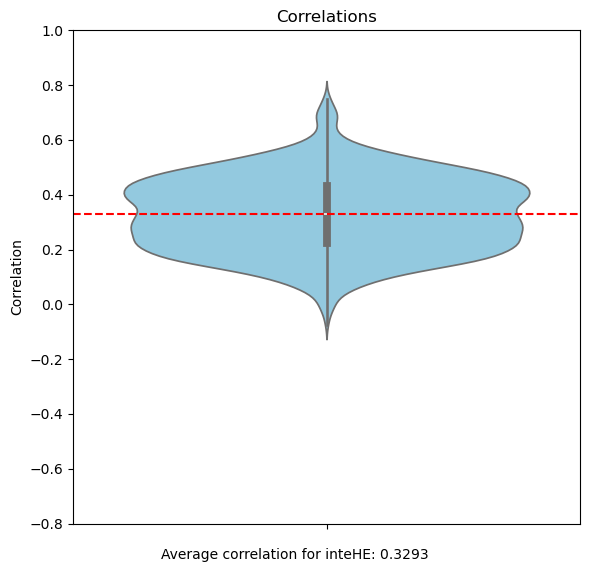

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设correlations_test_inteHE和correlations_test_HE已经是可用的数据列表或numpy数组

# 计算平均相关性
mean_correlation = np.mean(corr)
# 第一张图：inteHE的相关性
plt.figure(figsize=(6, 6))  # 创建新图形
sns.violinplot(y=corr, color="skyblue")
plt.title('Correlations')
plt.ylabel('Correlation')
plt.ylim(-0.8, 1)  # 固定纵轴的范围
# 显示平均相关性
plt.axhline(y=mean_correlation, color="red", linestyle="--")  # 使用虚线表示平均值
# 添加平均值信息
plt.figtext(0.5, 0.01, f"Average correlation for inteHE: {mean_correlation:.4f}", ha="center", fontsize=10, color="black")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Integrated HE to Harmony mRNA

In [20]:
# Assuming data_sample1_HEfeature and data_sample2_HEfeature are pandas DataFrames
# and you want to preserve the row index after SVD transformation

from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=128, n_iter=7, random_state=42)

# Fit SVD on the training data
svd.fit(data_sample1_integratedHE)

# Transform both training and test data
spot_tr_score_array = svd.transform(data_sample1_integratedHE)
spot_ts_score_array = svd.transform(data_sample2_integratedHE)

# Convert the numpy arrays back to pandas DataFrame and preserve the original index
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=data_sample1_integratedHE.index)
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=data_sample2_integratedHE.index)

In [21]:
import numpy as np
import logging

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_tr_score_array = spot_tr_score_df.to_numpy()

# 计算标准差并进行 reshape
train_sd = np.std(spot_tr_score_array, axis=1).reshape(-1, 1)
train_sd[train_sd == 0] = 1

# 进行标准化
spot_tr_score_array = (spot_tr_score_array - np.mean(spot_tr_score_array, axis=1).reshape(-1, 1)) / train_sd
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=spot_tr_score_df.index, columns=spot_tr_score_df.columns).astype(np.float32)

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_ts_score_array = spot_ts_score_df.to_numpy()

# 计算标准差并进行 reshape
test_sd = np.std(spot_ts_score_array, axis=1).reshape(-1, 1)
test_sd[test_sd == 0] = 1

# 进行标准化
spot_ts_score_array = (spot_ts_score_array - np.mean(spot_ts_score_array, axis=1).reshape(-1, 1)) / test_sd
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=spot_ts_score_df.index, columns=spot_ts_score_df.columns).astype(np.float32)

INFO:root:Running normalization ...
INFO:root:Running normalization ...


In [22]:
embedder_mod2 = TruncatedSVD(n_components=10)
train_gs = embedder_mod2.fit_transform(harmony_matrix1).astype(np.float32)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input = spot_tr_score_df
test_input = spot_ts_score_df

pred_dimx = spot_ts_score_df.shape[0]
pred_dimy = harmony_matrix2.shape[1]
y_pred = np.zeros((pred_dimx, pred_dimy), dtype=np.float32)

kernel = RBF(length_scale = 10)
krr = KernelRidge(alpha=0.1, kernel=kernel)

for _ in range(5):
    logging.info('Fitting KRR ... ')
    krr.fit(train_input, train_gs)  # 直接用完整数据集训练
    y_pred += (krr.predict(test_input) @ embedder_mod2.components_)  # 预测并累加

INFO:root:Fitting KRR ... 


INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 


In [24]:
import pandas as pd
import numpy as np

# Assuming test_input is a NumPy array and you want to convert it to a DataFrame
if isinstance(test_input, np.ndarray):
    test_input = pd.DataFrame(test_input)
    test_input.columns = test_input.columns.astype(str)

from scipy.stats import pearsonr
correlations = []
test_output = harmony_matrix2.values
# Ensure test_output and y_pred are NumPy arrays, if they are DataFrames, convert them using .values
test_output = test_output.values if isinstance(test_output, pd.DataFrame) else test_output
y_pred = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

for i in range(y_pred.shape[1]):
    corr = pearsonr(y_pred[:, i], test_output[:, i])[0]
    correlations.append(corr)

correlations_test_HE = np.array(correlations)
print(correlations_test_HE.shape)
mean_correlation_test_HE = np.nanmean(correlations_test_HE)
print(mean_correlation_test_HE)

(1923,)
0.10702880317308207


In [25]:

corr = np.zeros(y_pred.shape[1])
for i in range(y_pred.shape[1]):
    corr[i] = np.corrcoef(y_pred[:,i], test_output[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("max correlation: ", np.max(corr))
ind = np.argsort(np.sum(test_output, axis=0))[-50:]
print("mean correlation highly expressed genes: ", np.mean(corr[ind]))
ind = np.argsort(np.var(test_output, axis=0))[-50:]
print("mean correlation highly variable genes: ", np.mean(corr[ind]))

number of non-zero genes:  1923
max correlation:  0.6858994031102954
mean correlation highly expressed genes:  0.1984415955146316
mean correlation highly variable genes:  0.3672502932955561


In [26]:
corr = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    corr[i] = np.corrcoef(y_pred[i,:], test_output[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))

Mean correlation across cells:  0.3684406718701249


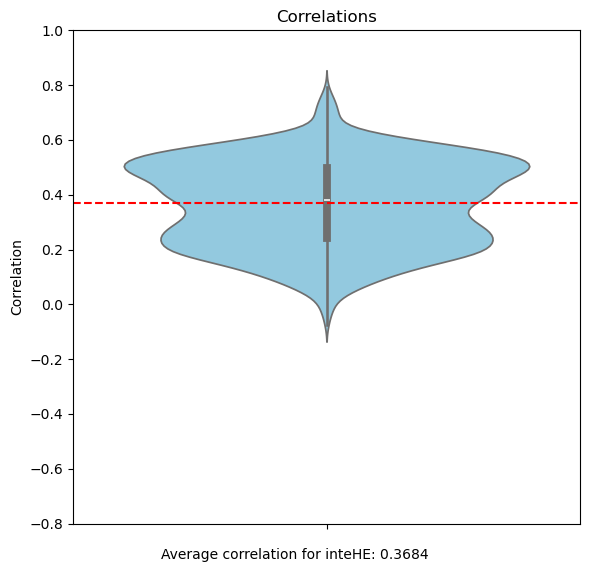

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设correlations_test_inteHE和correlations_test_HE已经是可用的数据列表或numpy数组

# 计算平均相关性
mean_correlation = np.mean(corr)
# 第一张图：inteHE的相关性
plt.figure(figsize=(6, 6))  # 创建新图形
sns.violinplot(y=corr, color="skyblue")
plt.title('Correlations')
plt.ylabel('Correlation')
plt.ylim(-0.8, 1)  # 固定纵轴的范围
# 显示平均相关性
plt.axhline(y=mean_correlation, color="red", linestyle="--")  # 使用虚线表示平均值
# 添加平均值信息
plt.figtext(0.5, 0.01, f"Average correlation for inteHE: {mean_correlation:.4f}", ha="center", fontsize=10, color="black")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Calulate on HE image

In [28]:
import scanpy as sc
import anndata as ad

# 处理第一个数据集 raw_matrix_df_11
adata_11 = ad.AnnData(data_sample1_count)

# 归一化
sc.pp.normalize_per_cell(adata_11, counts_per_cell_after=library_size_11_median)

# 对数变换
sc.pp.log1p(adata_11)

# 选取高度可变基因 (初始选1000个)
sc.pp.highly_variable_genes(adata_11, n_top_genes=1000)

# 获取第一个数据集的高度可变基因的索引
highly_variable_genes_11 = adata_11.var[adata_11.var['highly_variable']].index

# 处理第二个数据集 raw_matrix_df_FF
adata_FF = ad.AnnData(data_sample2_count)

# 归一化
sc.pp.normalize_per_cell(adata_FF, counts_per_cell_after=library_size_FF_median)

# 对数变换
sc.pp.log1p(adata_FF)

# 选取高度可变基因 (初始选1000个)
sc.pp.highly_variable_genes(adata_FF, n_top_genes=1000)

# 获取第二个数据集的高度可变基因的索引
highly_variable_genes_FF = adata_FF.var[adata_FF.var['highly_variable']].index

# 取两个数据集高度可变基因的并集
common_highly_variable_genes = highly_variable_genes_11.union(highly_variable_genes_FF)

# 只保留这些基因的数据
adata_11_filtered = adata_11[:, common_highly_variable_genes]
adata_FF_filtered = adata_FF[:, common_highly_variable_genes]

# 最终用于分析的数据
data_sample1_count_filtered_hvg = adata_11_filtered.to_df()
data_sample2_count_filtered_hvg = adata_FF_filtered.to_df()

print(data_sample1_count_filtered_hvg.head())
print(data_sample2_count_filtered_hvg.head())

                         A2M     ABCA2     ABCA3     ABCF2     ABCG4  \
Barcode                                                                
ACGGTGATACAACCGC-1  2.491893  2.404824  1.103698  1.103698  0.696964   
TATGGCCTAGCGGCTA-1  2.676060  2.469979  1.858031  0.000000  0.000000   
TAAGGTATCCACCGCT-1  3.764811  2.364203  1.760919  0.790476  0.000000   
TATTGAATCTCACGCC-1  2.408977  2.630685  1.324606  1.043969  0.000000   
ATAGGACTCATATGGC-1  2.410031  2.662678  1.661476  1.757938  0.000000   

                     ABHD16B     ABHD3     ABHD5  ABI3BP  AC007906.2  ...  \
Barcode                                                               ...   
ACGGTGATACAACCGC-1  0.408011  1.510008  0.920869     0.0         0.0  ...   
TATGGCCTAGCGGCTA-1  0.000000  1.309831  1.309831     0.0         0.0  ...   
TAAGGTATCCACCGCT-1  0.000000  1.528951  1.528951     0.0         0.0  ...   
TATTGAATCTCACGCC-1  0.000000  1.324606  1.043969     0.0         0.0  ...   
ATAGGACTCATATGGC-1  0.000000  0.7

In [29]:
embedder_mod2 = TruncatedSVD(n_components=10)
train_gs = embedder_mod2.fit_transform(data_sample1_count_filtered_hvg).astype(np.float32)

In [30]:
# Assuming data_sample1_HEfeature and data_sample2_HEfeature are pandas DataFrames
# and you want to preserve the row index after SVD transformation

from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=128, n_iter=7, random_state=42)

# Fit SVD on the training data
svd.fit(data_sample1_HEfeature)

# Transform both training and test data
spot_tr_score_array = svd.transform(data_sample1_HEfeature)
spot_ts_score_array = svd.transform(data_sample2_HEfeature)

# Convert the numpy arrays back to pandas DataFrame and preserve the original index
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=data_sample1_HEfeature.index)
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=data_sample2_HEfeature.index)

In [31]:
import numpy as np
import logging

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_tr_score_array = spot_tr_score_df.to_numpy()

# 计算标准差并进行 reshape
train_sd = np.std(spot_tr_score_array, axis=1).reshape(-1, 1)
train_sd[train_sd == 0] = 1

# 进行标准化
spot_tr_score_array = (spot_tr_score_array - np.mean(spot_tr_score_array, axis=1).reshape(-1, 1)) / train_sd
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=spot_tr_score_df.index, columns=spot_tr_score_df.columns).astype(np.float32)

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_ts_score_array = spot_ts_score_df.to_numpy()

# 计算标准差并进行 reshape
test_sd = np.std(spot_ts_score_array, axis=1).reshape(-1, 1)
test_sd[test_sd == 0] = 1

# 进行标准化
spot_ts_score_array = (spot_ts_score_array - np.mean(spot_ts_score_array, axis=1).reshape(-1, 1)) / test_sd
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=spot_ts_score_df.index, columns=spot_ts_score_df.columns).astype(np.float32)

INFO:root:Running normalization ...
INFO:root:Running normalization ...


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input = spot_tr_score_df
test_input = spot_ts_score_df

pred_dimx = spot_ts_score_df.shape[0]
pred_dimy = data_sample2_count_filtered_hvg.shape[1]
y_pred = np.zeros((pred_dimx, pred_dimy), dtype=np.float32)

kernel = RBF(length_scale = 10)
krr = KernelRidge(alpha=0.1, kernel=kernel)

for _ in range(5):
    logging.info('Fitting KRR ... ')
    krr.fit(train_input, train_gs)  # 直接用完整数据集训练
    y_pred += (krr.predict(test_input) @ embedder_mod2.components_)  # 预测并累加

INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 


In [33]:
import pandas as pd
import numpy as np

# Assuming test_input is a NumPy array and you want to convert it to a DataFrame
if isinstance(test_input, np.ndarray):
    test_input = pd.DataFrame(test_input)
    test_input.columns = test_input.columns.astype(str)

from scipy.stats import pearsonr
correlations = []

test_output = data_sample2_count_filtered_hvg.values
# Ensure test_output and y_pred are NumPy arrays, if they are DataFrames, convert them using .values
test_output = test_output.values if isinstance(test_output, pd.DataFrame) else test_output
y_pred = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

for i in range(y_pred.shape[1]):
    corr = pearsonr(y_pred[:, i], test_output[:, i])[0]
    correlations.append(corr)

correlations_test_HE = np.array(correlations)
print(correlations_test_HE.shape)
mean_correlation_test_HE = np.nanmean(correlations_test_HE)
print(mean_correlation_test_HE)

/tmp/ipykernel_101914/3023280303.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y_pred[:, i], test_output[:, i])[0]


(1851,)
0.11363448317838355


In [34]:

corr = np.zeros(y_pred.shape[1])
for i in range(y_pred.shape[1]):
    corr[i] = np.corrcoef(y_pred[:,i], test_output[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("max correlation: ", np.max(corr))
ind = np.argsort(np.sum(test_output, axis=0))[-50:]
print("mean correlation highly expressed genes: ", np.mean(corr[ind]))
ind = np.argsort(np.var(test_output, axis=0))[-50:]
print("mean correlation highly variable genes: ", np.mean(corr[ind]))

number of non-zero genes:  1850
max correlation:  0.7056486192445653
mean correlation highly expressed genes:  0.0931836392247389
mean correlation highly variable genes:  0.20561358318875594


/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [35]:

corr = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    corr[i] = np.corrcoef(y_pred[i,:], test_output[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))


Mean correlation across cells:  0.4486862933259639


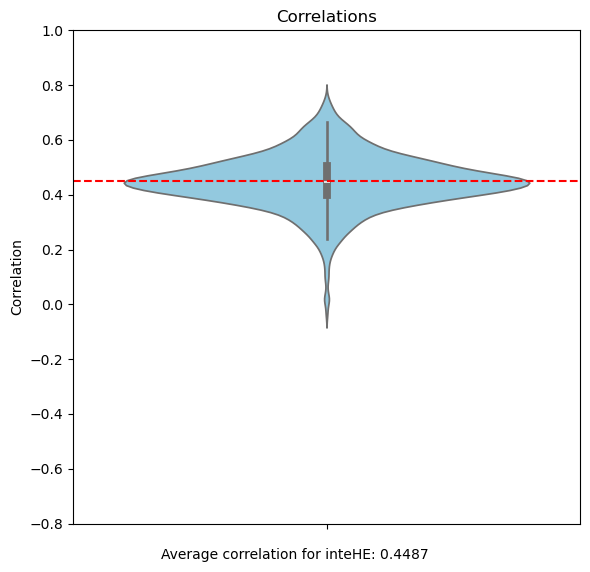

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设correlations_test_inteHE和correlations_test_HE已经是可用的数据列表或numpy数组

# 计算平均相关性
mean_correlation = np.mean(corr)
# 第一张图：inteHE的相关性
plt.figure(figsize=(6, 6))  # 创建新图形
sns.violinplot(y=corr, color="skyblue")
plt.title('Correlations')
plt.ylabel('Correlation')
plt.ylim(-0.8, 1)  # 固定纵轴的范围
# 显示平均相关性
plt.axhline(y=mean_correlation, color="red", linestyle="--")  # 使用虚线表示平均值
# 添加平均值信息
plt.figtext(0.5, 0.01, f"Average correlation for inteHE: {mean_correlation:.4f}", ha="center", fontsize=10, color="black")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## InteHE

In [37]:
# Assuming data_sample1_HEfeature and data_sample2_HEfeature are pandas DataFrames
# and you want to preserve the row index after SVD transformation

from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=128, n_iter=7, random_state=42)

# Fit SVD on the training data
svd.fit(data_sample1_integratedHE)

# Transform both training and test data
spot_tr_score_array = svd.transform(data_sample1_integratedHE)
spot_ts_score_array = svd.transform(data_sample2_integratedHE)

# Convert the numpy arrays back to pandas DataFrame and preserve the original index
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=data_sample1_integratedHE.index)
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=data_sample2_integratedHE.index)

In [38]:
import numpy as np
import logging

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_tr_score_array = spot_tr_score_df.to_numpy()

# 计算标准差并进行 reshape
train_sd = np.std(spot_tr_score_array, axis=1).reshape(-1, 1)
train_sd[train_sd == 0] = 1

# 进行标准化
spot_tr_score_array = (spot_tr_score_array - np.mean(spot_tr_score_array, axis=1).reshape(-1, 1)) / train_sd
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=spot_tr_score_df.index, columns=spot_tr_score_df.columns).astype(np.float32)

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_ts_score_array = spot_ts_score_df.to_numpy()

# 计算标准差并进行 reshape
test_sd = np.std(spot_ts_score_array, axis=1).reshape(-1, 1)
test_sd[test_sd == 0] = 1

# 进行标准化
spot_ts_score_array = (spot_ts_score_array - np.mean(spot_ts_score_array, axis=1).reshape(-1, 1)) / test_sd
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=spot_ts_score_df.index, columns=spot_ts_score_df.columns).astype(np.float32)

INFO:root:Running normalization ...
INFO:root:Running normalization ...


In [39]:
embedder_mod2 = TruncatedSVD(n_components=10)
train_gs = embedder_mod2.fit_transform(data_sample1_count_filtered_hvg).astype(np.float32)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input = spot_tr_score_df
test_input = spot_ts_score_df

pred_dimx = spot_ts_score_df.shape[0]
pred_dimy = data_sample2_count_filtered_hvg.shape[1]
y_pred = np.zeros((pred_dimx, pred_dimy), dtype=np.float32)

kernel = RBF(length_scale = 10)
krr = KernelRidge(alpha=0.1, kernel=kernel)

for _ in range(5):
    logging.info('Fitting KRR ... ')
    krr.fit(train_input, train_gs)  # 直接用完整数据集训练
    y_pred += (krr.predict(test_input) @ embedder_mod2.components_)  # 预测并累加

INFO:root:Fitting KRR ... 


INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 


In [41]:
import pandas as pd
import numpy as np

# Assuming test_input is a NumPy array and you want to convert it to a DataFrame
if isinstance(test_input, np.ndarray):
    test_input = pd.DataFrame(test_input)
    test_input.columns = test_input.columns.astype(str)

from scipy.stats import pearsonr
correlations = []

test_output = data_sample2_count_filtered_hvg.values
# Ensure test_output and y_pred are NumPy arrays, if they are DataFrames, convert them using .values
test_output = test_output.values if isinstance(test_output, pd.DataFrame) else test_output
y_pred = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

for i in range(y_pred.shape[1]):
    corr = pearsonr(y_pred[:, i], test_output[:, i])[0]
    correlations.append(corr)

correlations_test_HE = np.array(correlations)
print(correlations_test_HE.shape)
mean_correlation_test_HE = np.nanmean(correlations_test_HE)
print(mean_correlation_test_HE)

/tmp/ipykernel_101914/3023280303.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y_pred[:, i], test_output[:, i])[0]


(1851,)
0.10026987005219311


In [42]:

corr = np.zeros(y_pred.shape[1])
for i in range(y_pred.shape[1]):
    corr[i] = np.corrcoef(y_pred[:,i], test_output[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("max correlation: ", np.max(corr))
ind = np.argsort(np.sum(test_output, axis=0))[-50:]
print("mean correlation highly expressed genes: ", np.mean(corr[ind]))
ind = np.argsort(np.var(test_output, axis=0))[-50:]
print("mean correlation highly variable genes: ", np.mean(corr[ind]))

number of non-zero genes:  1850
max correlation:  0.6289825963734823
mean correlation highly expressed genes:  0.069664498253627
mean correlation highly variable genes:  0.19660192128472495


/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/work2/10000/wl87/anaconda3/envs/my_ml_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [43]:

corr = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    corr[i] = np.corrcoef(y_pred[i,:], test_output[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))

Mean correlation across cells:  0.40214752146177357


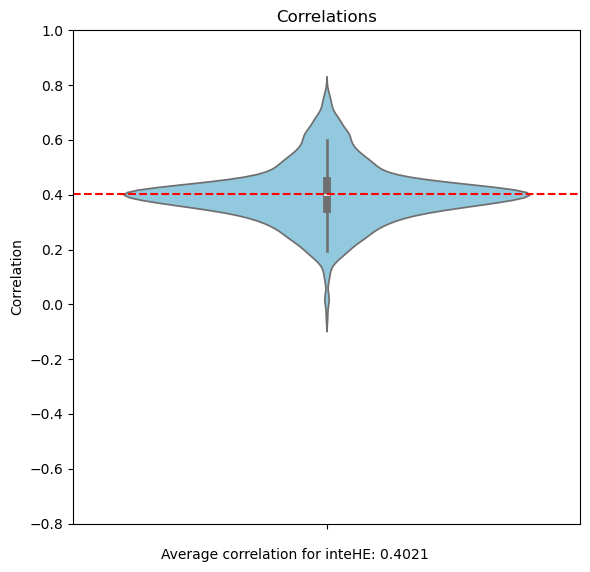

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设correlations_test_inteHE和correlations_test_HE已经是可用的数据列表或numpy数组

# 计算平均相关性
mean_correlation = np.mean(corr)
# 第一张图：inteHE的相关性
plt.figure(figsize=(6, 6))  # 创建新图形
sns.violinplot(y=corr, color="skyblue")
plt.title('Correlations')
plt.ylabel('Correlation')
plt.ylim(-0.8, 1)  # 固定纵轴的范围
# 显示平均相关性
plt.axhline(y=mean_correlation, color="red", linestyle="--")  # 使用虚线表示平均值
# 添加平均值信息
plt.figtext(0.5, 0.01, f"Average correlation for inteHE: {mean_correlation:.4f}", ha="center", fontsize=10, color="black")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Integrate both mRNA & HE

In [45]:
data_sample1_integratedEXPR = pd.read_feather(directory_path + "Lung_data_sample1_integrated_expr10k.feather")
data_sample2_integratedEXPR = pd.read_feather(directory_path + "Lung_data_sample2_integrated_expr10k.feather")
data_sample1_integratedEXPR.set_index('Barcode', inplace=True)
data_sample1_integratedEXPR = data_sample1_integratedEXPR.loc[data_sample1_celltype.index]
data_sample2_integratedEXPR.set_index('Barcode', inplace=True)
data_sample2_integratedEXPR = data_sample2_integratedEXPR.loc[data_sample2_celltype.index]

In [46]:
# 找到filtered_genes和两个DataFrame列名的交集
common_genes = set(common_highly_variable_genes) & set(data_sample1_integratedEXPR.columns) & set(data_sample2_integratedEXPR.columns)

# 将交集转换为列表
common_genes_list = list(common_genes)

# 使用交集列表过滤数据
data_sample1_integratedEXPR_filtered = data_sample1_integratedEXPR.loc[:, common_genes_list]
data_sample2_integratedEXPR_filtered = data_sample2_integratedEXPR.loc[:, common_genes_list]

In [47]:
print(data_sample1_integratedEXPR.shape)
print(common_highly_variable_genes.shape)
print(data_sample1_integratedEXPR_filtered.shape)

(6121, 10000)
(1851,)
(6121, 1449)


In [48]:
embedder_mod2 = TruncatedSVD(n_components=10)
train_gs = embedder_mod2.fit_transform(data_sample1_integratedEXPR_filtered).astype(np.float32)

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input = spot_tr_score_df
test_input = spot_ts_score_df

pred_dimx = spot_ts_score_df.shape[0]
pred_dimy = data_sample2_integratedEXPR_filtered.shape[1]
y_pred = np.zeros((pred_dimx, pred_dimy), dtype=np.float32)

kernel = RBF(length_scale = 10)
krr = KernelRidge(alpha=0.1, kernel=kernel)

for _ in range(5):
    logging.info('Fitting KRR ... ')
    krr.fit(train_input, train_gs)  # 直接用完整数据集训练
    y_pred += (krr.predict(test_input) @ embedder_mod2.components_)  # 预测并累加

INFO:root:Fitting KRR ... 


INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 


In [50]:
import pandas as pd
import numpy as np

# Assuming test_input is a NumPy array and you want to convert it to a DataFrame
if isinstance(test_input, np.ndarray):
    test_input = pd.DataFrame(test_input)
    test_input.columns = test_input.columns.astype(str)

from scipy.stats import pearsonr
correlations = []

test_output = data_sample2_integratedEXPR_filtered.values
# Ensure test_output and y_pred are NumPy arrays, if they are DataFrames, convert them using .values
test_output = test_output.values if isinstance(test_output, pd.DataFrame) else test_output
y_pred = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

for i in range(y_pred.shape[1]):
    corr = pearsonr(y_pred[:, i], test_output[:, i])[0]
    correlations.append(corr)

correlations_test_HE = np.array(correlations)
print(correlations_test_HE.shape)
mean_correlation_test_HE = np.nanmean(correlations_test_HE)
print(mean_correlation_test_HE)

(1449,)
0.27042606181291506


In [51]:

corr = np.zeros(y_pred.shape[1])
for i in range(y_pred.shape[1]):
    corr[i] = np.corrcoef(y_pred[:,i], test_output[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("max correlation: ", np.max(corr))
ind = np.argsort(np.sum(test_output, axis=0))[-50:]
print("mean correlation highly expressed genes: ", np.mean(corr[ind]))
ind = np.argsort(np.var(test_output, axis=0))[-50:]
print("mean correlation highly variable genes: ", np.mean(corr[ind]))

number of non-zero genes:  1449
max correlation:  0.6907727124987656
mean correlation highly expressed genes:  0.4786348397070965
mean correlation highly variable genes:  0.07978776920103198


In [52]:

corr = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    corr[i] = np.corrcoef(y_pred[i,:], test_output[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))

Mean correlation across cells:  0.19412234367501316


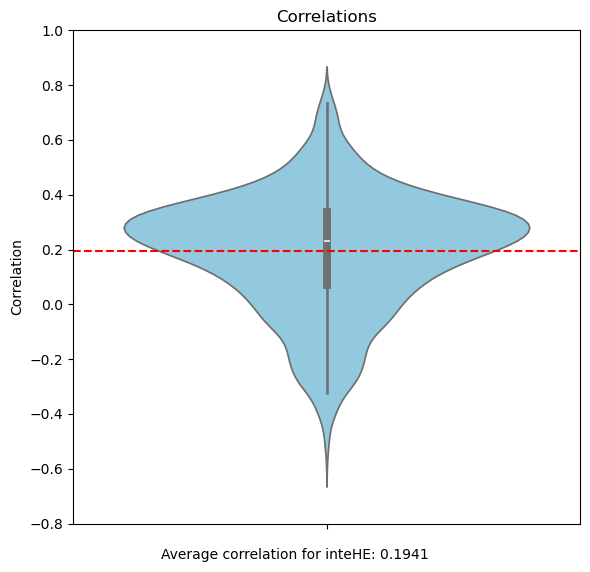

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设correlations_test_inteHE和correlations_test_HE已经是可用的数据列表或numpy数组

# 计算平均相关性
mean_correlation = np.mean(corr)
# 第一张图：inteHE的相关性
plt.figure(figsize=(6, 6))  # 创建新图形
sns.violinplot(y=corr, color="skyblue")
plt.title('Correlations')
plt.ylabel('Correlation')
plt.ylim(-0.8, 1)  # 固定纵轴的范围
# 显示平均相关性
plt.axhline(y=mean_correlation, color="red", linestyle="--")  # 使用虚线表示平均值
# 添加平均值信息
plt.figtext(0.5, 0.01, f"Average correlation for inteHE: {mean_correlation:.4f}", ha="center", fontsize=10, color="black")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

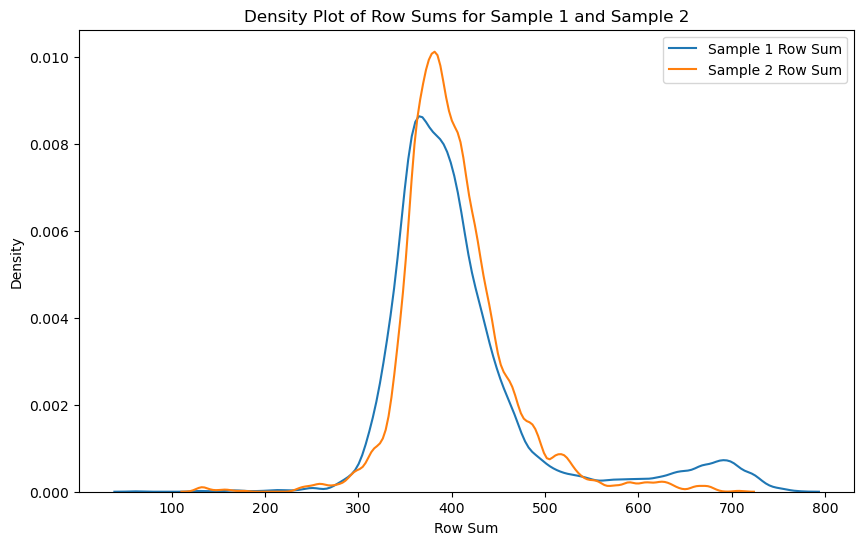

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 计算每个样本的行和
data_sample1_row_sum = harmony_matrix1.sum(axis=1)
data_sample2_row_sum = harmony_matrix2.sum(axis=1)

# 绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(data_sample1_row_sum, bw_adjust=0.5, label='Sample 1 Row Sum')
sns.kdeplot(data_sample2_row_sum, bw_adjust=0.5, label='Sample 2 Row Sum')

plt.title('Density Plot of Row Sums for Sample 1 and Sample 2')
plt.xlabel('Row Sum')
plt.ylabel('Density')
plt.legend()
plt.show()

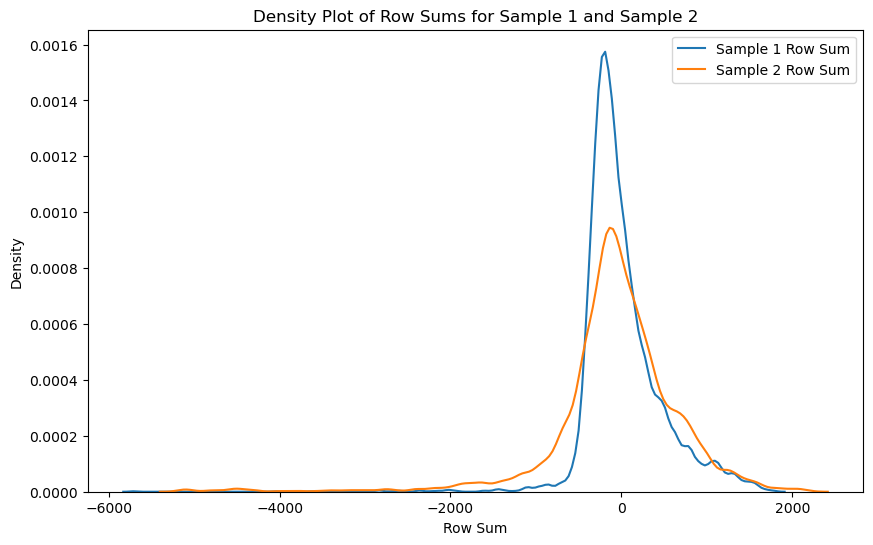

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 计算每个样本的行和
data_sample1_row_sum = data_sample1_integratedEXPR.sum(axis=1)
data_sample2_row_sum = data_sample2_integratedEXPR.sum(axis=1)

# 绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(data_sample1_row_sum, bw_adjust=0.5, label='Sample 1 Row Sum')
sns.kdeplot(data_sample2_row_sum, bw_adjust=0.5, label='Sample 2 Row Sum')

plt.title('Density Plot of Row Sums for Sample 1 and Sample 2')
plt.xlabel('Row Sum')
plt.ylabel('Density')
plt.legend()
plt.show()

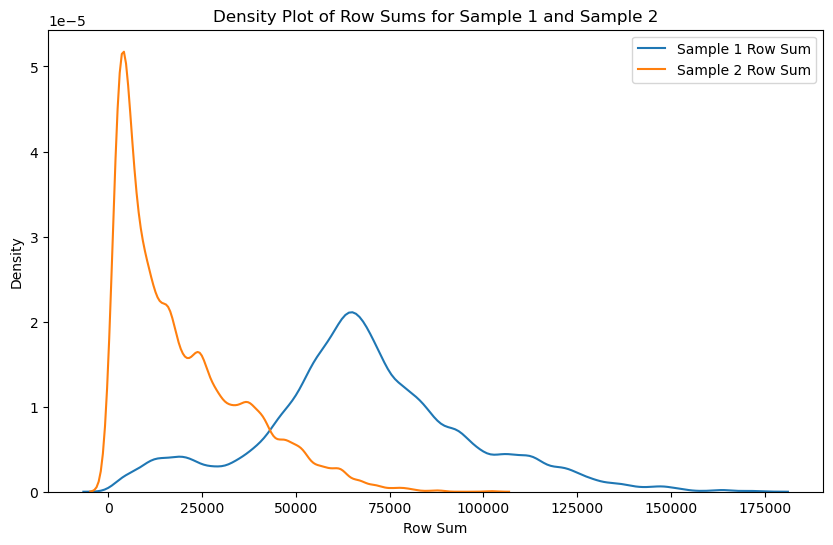

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 计算每个样本的行和
data_sample1_row_sum = data_sample1_count.sum(axis=1)
data_sample2_row_sum = data_sample2_count.sum(axis=1)

# 绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(data_sample1_row_sum, bw_adjust=0.5, label='Sample 1 Row Sum')
sns.kdeplot(data_sample2_row_sum, bw_adjust=0.5, label='Sample 2 Row Sum')

plt.title('Density Plot of Row Sums for Sample 1 and Sample 2')
plt.xlabel('Row Sum')
plt.ylabel('Density')
plt.legend()
plt.show()

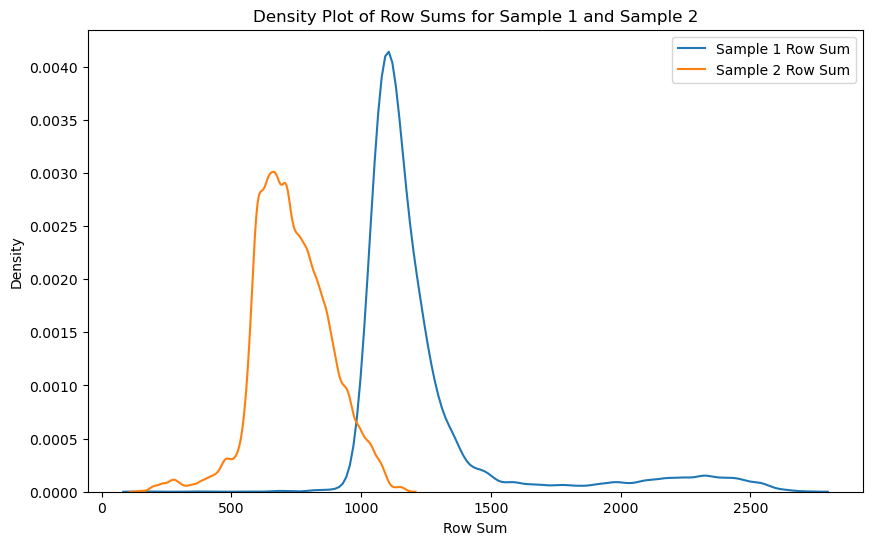

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 计算每个样本的行和
data_sample1_row_sum = data_sample1_count_filtered_hvg.sum(axis=1)
data_sample2_row_sum = data_sample2_count_filtered_hvg.sum(axis=1)

# 绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(data_sample1_row_sum, bw_adjust=0.5, label='Sample 1 Row Sum')
sns.kdeplot(data_sample2_row_sum, bw_adjust=0.5, label='Sample 2 Row Sum')

plt.title('Density Plot of Row Sums for Sample 1 and Sample 2')
plt.xlabel('Row Sum')
plt.ylabel('Density')
plt.legend()
plt.show()

In [69]:
# harmony的数值 全部乘以100
harmony_matrix1_ = harmony_matrix1 / 100
harmony_matrix2_ = harmony_matrix2 / 100


In [59]:
# Assuming data_sample1_HEfeature and data_sample2_HEfeature are pandas DataFrames
# and you want to preserve the row index after SVD transformation

from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=128, n_iter=7, random_state=42)

# Fit SVD on the training data
svd.fit(data_sample1_integratedHE)

# Transform both training and test data
spot_tr_score_array = svd.transform(data_sample1_integratedHE)
spot_ts_score_array = svd.transform(data_sample2_integratedHE)

# Convert the numpy arrays back to pandas DataFrame and preserve the original index
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=data_sample1_integratedHE.index)
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=data_sample2_integratedHE.index)

In [60]:
import numpy as np
import logging

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_tr_score_array = spot_tr_score_df.to_numpy()

# 计算标准差并进行 reshape
train_sd = np.std(spot_tr_score_array, axis=1).reshape(-1, 1)
train_sd[train_sd == 0] = 1

# 进行标准化
spot_tr_score_array = (spot_tr_score_array - np.mean(spot_tr_score_array, axis=1).reshape(-1, 1)) / train_sd
spot_tr_score_df = pd.DataFrame(spot_tr_score_array, index=spot_tr_score_df.index, columns=spot_tr_score_df.columns).astype(np.float32)

logging.info('Running normalization ...')

# 将 DataFrame 转换为 NumPy 数组
spot_ts_score_array = spot_ts_score_df.to_numpy()

# 计算标准差并进行 reshape
test_sd = np.std(spot_ts_score_array, axis=1).reshape(-1, 1)
test_sd[test_sd == 0] = 1

# 进行标准化
spot_ts_score_array = (spot_ts_score_array - np.mean(spot_ts_score_array, axis=1).reshape(-1, 1)) / test_sd
spot_ts_score_df = pd.DataFrame(spot_ts_score_array, index=spot_ts_score_df.index, columns=spot_ts_score_df.columns).astype(np.float32)

INFO:root:Running normalization ...
INFO:root:Running normalization ...


In [70]:
embedder_mod2 = TruncatedSVD(n_components=10)
train_gs = embedder_mod2.fit_transform(harmony_matrix1_).astype(np.float32)

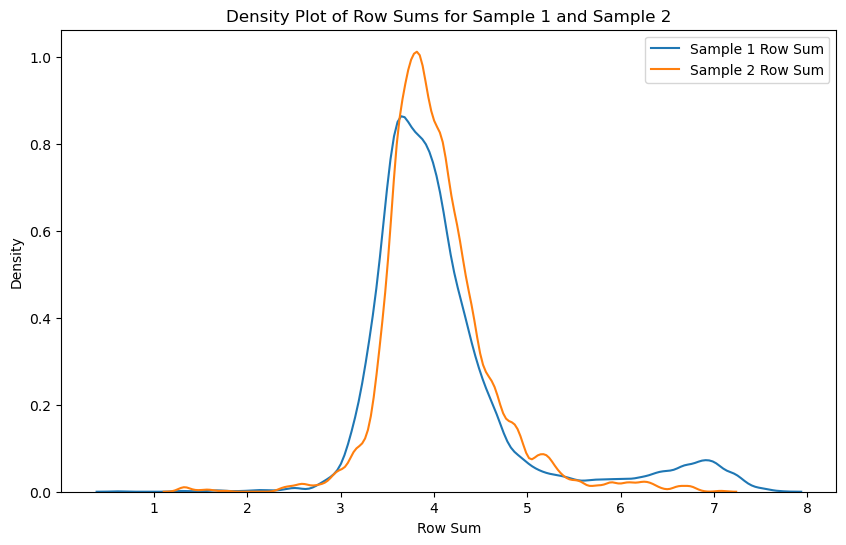

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 计算每个样本的行和
data_sample1_row_sum = harmony_matrix1_.sum(axis=1)
data_sample2_row_sum = harmony_matrix2_.sum(axis=1)

# 绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(data_sample1_row_sum, bw_adjust=0.5, label='Sample 1 Row Sum')
sns.kdeplot(data_sample2_row_sum, bw_adjust=0.5, label='Sample 2 Row Sum')

plt.title('Density Plot of Row Sums for Sample 1 and Sample 2')
plt.xlabel('Row Sum')
plt.ylabel('Density')
plt.legend()
plt.show()

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input = spot_tr_score_df
test_input = spot_ts_score_df

pred_dimx = spot_ts_score_df.shape[0]
pred_dimy = harmony_matrix2_.shape[1]
y_pred = np.zeros((pred_dimx, pred_dimy), dtype=np.float32)

kernel = RBF(length_scale = 10)
krr = KernelRidge(alpha=0.1, kernel=kernel)

for _ in range(5):
    logging.info('Fitting KRR ... ')
    krr.fit(train_input, train_gs)  # 直接用完整数据集训练
    y_pred += (krr.predict(test_input) @ embedder_mod2.components_)  # 预测并累加

INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 
INFO:root:Fitting KRR ... 


In [73]:
import pandas as pd
import numpy as np

# Assuming test_input is a NumPy array and you want to convert it to a DataFrame
if isinstance(test_input, np.ndarray):
    test_input = pd.DataFrame(test_input)
    test_input.columns = test_input.columns.astype(str)

from scipy.stats import pearsonr
correlations = []
test_output = harmony_matrix2_.values
# Ensure test_output and y_pred are NumPy arrays, if they are DataFrames, convert them using .values
test_output = test_output.values if isinstance(test_output, pd.DataFrame) else test_output
y_pred = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

for i in range(y_pred.shape[1]):
    corr = pearsonr(y_pred[:, i], test_output[:, i])[0]
    correlations.append(corr)

correlations_test_HE = np.array(correlations)
print(correlations_test_HE.shape)
mean_correlation_test_HE = np.nanmean(correlations_test_HE)
print(mean_correlation_test_HE)

(1923,)
0.10699789894064415


In [74]:
corr = np.zeros(y_pred.shape[1])
for i in range(y_pred.shape[1]):
    corr[i] = np.corrcoef(y_pred[:,i], test_output[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("max correlation: ", np.max(corr))
ind = np.argsort(np.sum(test_output, axis=0))[-50:]
print("mean correlation highly expressed genes: ", np.mean(corr[ind]))
ind = np.argsort(np.var(test_output, axis=0))[-50:]
print("mean correlation highly variable genes: ", np.mean(corr[ind]))

number of non-zero genes:  1923
max correlation:  0.686194560159146
mean correlation highly expressed genes:  0.1984055041919657
mean correlation highly variable genes:  0.36741844510121213


In [75]:

corr = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    corr[i] = np.corrcoef(y_pred[i,:], test_output[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))


Mean correlation across cells:  0.36848068805885553
